## Run notebook from project root

Adjust `path_to_top_dir = "../../"`

In [ ]:
import sys
import os

path_to_top_dir = "../"
sys.path.append(os.path.abspath(path_to_top_dir))
root_path = os.path.abspath(path_to_top_dir)
root_path,os.getcwd()

In [ ]:
from optuna_studies.hyperparams_base_model import ScentTrainer


c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.



############################################################
#                     Initialize MCFs                      #
############################################################

Filter                                        Min        Max
------------------------------------------------------------
LogP                                         0.06       4.91
Molecular Weight                           100.12     282.46
HBAB + HBD                                   0.00       5.00
TPSA                                         0.00      63.32
Rotatable Bonds                              0.00      11.00
NO2 Groups                                   0.00       0.00
Heteroatoms                                  0.00       4.00
Aromatic Rings                               0.00       1.00
Atom Count                                   0.00      20.00
Triple Bonds                                 0.00       0.00
Oxygen Chain Length                          0.00       1.00

#####################

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
from src.submodels.gflownet.algo.config import TBVariant
from src.submodels.gflownet.config import Config,init_empty
import torch
import gc
import optuna

In [3]:
def objective_function(optuna_trial):
    algo_variant = TBVariant.SubTB1 #optuna_trial.suggest_categorical("algo_variant", [TBVariant.SubTB1])
    algo_sampling_tau = optuna_trial.suggest_float("algo_sampling_tau_log", 0.8, 0.9999, log=True) #try log scale 0.8 - 0.9999
    algo_Z_learning_rate = optuna_trial.suggest_float("algo_Z_learning_rate",  1e-5,1e-1, log=True) #1e-5 to 1e-1

    opt_learning_rate = optuna_trial.suggest_float("opt_learning_rate",1e-5, 1e-1, log=True)
    opt_momentum = 0.651294024078677 #optuna_trial.suggest_float("opt_momentum", 0.651294024078677 , 0.651294024078677) # Choose the best value
    opt_clip_grad_param = optuna_trial.suggest_float("opt_clip_grad_param_log", 0.1, 100, log=True) # 0.1 - 50 (Try to change it to log scale) if it doesnt work rename it
    opt_weight_decay = 3.9731330248837407e-07 #optuna_trial.suggest_float("opt_weight_decay",  3.9731330248837407e-07,3.9731330248837407e-07, log=True) # Fix

    

   


    # Initialize default hyperprameters
    config = init_empty(Config())

    # For CPU
    config.device = torch.device('cpu')
    config.num_workers = 0
    config.log_dir ="./logs/hyper2"
    config.overwrite_existing_exp=True

    config.validate_every=1000
    config.algo.num_from_policy = 32
    config.algo.num_from_dataset = 32
    config.algo.valid_num_from_policy= 32
    config.algo.valid_num_from_dataset= 32
    config.num_training_steps = 400 #10_000
    config.print_every =400


    config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
    config.num_validation_gen_steps = 1
    config.overwrite_existing_exp=True
    config.algo.tb.mask_invalid_rewards = False
    config.algo.tb.std_cut_losses = False
    config.algo.tb.std_cut_scale = 1


    # OPTUNA PARAMETERS
    # Algo
    config.algo.tb.variant = algo_variant 
    config.algo.sampling_tau = algo_sampling_tau
    config.algo.tb.Z_learning_rate = algo_Z_learning_rate
    # Opt
    config.opt.clip_grad_param = opt_clip_grad_param
    config.opt.momentum = opt_momentum
    config.opt.learning_rate = opt_learning_rate
    config.opt.weight_decay = opt_weight_decay
    



    gc.collect()
    trainer = ScentTrainer(config, print_config=False, optuna_trial=optuna_trial)


    trainer.run(logger=None)
    loss = trainer.track_training_loss

    # Ensure cleanup
        
    trainer.terminate()  # Ensure cleanup
    del trainer  # Remove the reference
    gc.collect()  # Force garbage collection"""


    
 
    return loss

In [25]:
0.00001

1e-05

In [24]:
1e-5, 1e-1

(1e-05, 0.1)

In [ ]:


base_dir = os.path.dirname(os.path.abspath(__file__))

studyname = "gflownet3"
db_path = os.path.join(base_dir, "studies", f"{studyname}.db")
study = optuna.create_study(
    direction="minimize", 
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=10, 
        max_resource='auto', 
        reduction_factor=3, 
        bootstrap_count=0
        ),
    study_name=studyname,
    storage=f"sqlite:///{db_path}",  
    load_if_exists=True
    )
#study.optimize(objective_function, timeout=24*60*60)#n_trials=50)
#study.optimize(objective_function,n_trials=2)

[I 2025-05-20 16:14:31,213] Using an existing study with name 'gflownet3' instead of creating a new one.


In [76]:
study.optimize(objective_function, timeout=21*60*60)#n_trials=50)

19/05/2025 11:25:41 - INFO - logger - Starting training


[I 2025-05-19 11:29:32,581] Trial 802 pruned. 


19/05/2025 11:29:35 - INFO - logger - Starting training


[I 2025-05-19 11:41:25,824] Trial 803 pruned. 


19/05/2025 11:41:29 - INFO - logger - Starting training
19/05/2025 12:05:53 - INFO - logger - Stop training at iteration 62


[I 2025-05-19 12:05:54,987] Trial 804 finished with value: 203.57931823730468 and parameters: {'algo_sampling_tau_log': 0.8161722447077869, 'algo_Z_learning_rate': 0.0031034792027002417, 'opt_learning_rate': 0.00019959512174558811, 'opt_clip_grad_param_log': 11.294125733630954}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 12:05:58 - INFO - logger - Starting training
19/05/2025 12:25:05 - INFO - logger - Stop training at iteration 36


[I 2025-05-19 12:25:06,365] Trial 805 finished with value: 290.6158752441406 and parameters: {'algo_sampling_tau_log': 0.8536418572770016, 'algo_Z_learning_rate': 0.0017754588910382908, 'opt_learning_rate': 0.0004450743649206459, 'opt_clip_grad_param_log': 28.79680018002472}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 12:25:10 - INFO - logger - Starting training
19/05/2025 12:42:29 - INFO - logger - Stop training at iteration 37


[I 2025-05-19 12:42:30,169] Trial 806 finished with value: 2019.7370346069335 and parameters: {'algo_sampling_tau_log': 0.8200366402099819, 'algo_Z_learning_rate': 2.8126338094573586e-05, 'opt_learning_rate': 0.0003492975565545987, 'opt_clip_grad_param_log': 16.4301498071328}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 12:42:33 - INFO - logger - Starting training
19/05/2025 13:02:19 - INFO - logger - Stop training at iteration 43


[I 2025-05-19 13:02:21,230] Trial 807 finished with value: 757.5273864746093 and parameters: {'algo_sampling_tau_log': 0.8250672936887, 'algo_Z_learning_rate': 1.4576231536711411e-05, 'opt_learning_rate': 0.0002947095999209363, 'opt_clip_grad_param_log': 32.66598208812794}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 13:02:26 - INFO - logger - Starting training


[I 2025-05-19 13:05:57,357] Trial 808 pruned. 


19/05/2025 13:06:00 - INFO - logger - Starting training
19/05/2025 13:23:20 - INFO - logger - Stop training at iteration 45


[I 2025-05-19 13:23:21,723] Trial 809 finished with value: 339.3116790771484 and parameters: {'algo_sampling_tau_log': 0.8131362248456647, 'algo_Z_learning_rate': 4.2158302668895215e-05, 'opt_learning_rate': 0.0002544140460796011, 'opt_clip_grad_param_log': 26.25319111767116}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 13:23:24 - INFO - logger - Starting training


[I 2025-05-19 13:32:31,519] Trial 810 pruned. 


19/05/2025 13:32:34 - INFO - logger - Starting training


[I 2025-05-19 13:34:04,072] Trial 811 pruned. 


19/05/2025 13:34:07 - INFO - logger - Starting training


[I 2025-05-19 13:35:23,044] Trial 812 pruned. 


19/05/2025 13:35:26 - INFO - logger - Starting training
19/05/2025 14:06:31 - INFO - logger - Stop training at iteration 71


[I 2025-05-19 14:06:32,373] Trial 813 finished with value: 302.4318283081055 and parameters: {'algo_sampling_tau_log': 0.9723236265661569, 'algo_Z_learning_rate': 4.8779360498400766e-05, 'opt_learning_rate': 0.00022005008303006802, 'opt_clip_grad_param_log': 9.67120681568666}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 14:06:35 - INFO - logger - Starting training
19/05/2025 14:35:47 - INFO - logger - Stop training at iteration 72


[I 2025-05-19 14:35:48,312] Trial 814 finished with value: 273.9529663085938 and parameters: {'algo_sampling_tau_log': 0.8569397072179337, 'algo_Z_learning_rate': 0.0015425871583383283, 'opt_learning_rate': 7.980034248553154e-05, 'opt_clip_grad_param_log': 22.116672876877885}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 14:35:51 - INFO - logger - Starting training


[I 2025-05-19 14:38:26,910] Trial 815 pruned. 


19/05/2025 14:38:30 - INFO - logger - Starting training


[I 2025-05-19 14:55:04,917] Trial 816 pruned. 


19/05/2025 14:55:09 - INFO - logger - Starting training
19/05/2025 15:31:40 - INFO - logger - Stop training at iteration 74


[I 2025-05-19 15:31:42,048] Trial 817 finished with value: 248.14974365234374 and parameters: {'algo_sampling_tau_log': 0.8190890636781041, 'algo_Z_learning_rate': 0.0012638339932498149, 'opt_learning_rate': 2.809557640771896e-05, 'opt_clip_grad_param_log': 28.467070686381234}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 15:31:45 - INFO - logger - Starting training
19/05/2025 15:57:23 - INFO - logger - Stop training at iteration 57


[I 2025-05-19 15:57:24,837] Trial 818 finished with value: 2305.189172363281 and parameters: {'algo_sampling_tau_log': 0.9817826002858163, 'algo_Z_learning_rate': 0.0005841461034003985, 'opt_learning_rate': 0.0004125197507328148, 'opt_clip_grad_param_log': 43.30592672755009}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 15:57:28 - INFO - logger - Starting training


[I 2025-05-19 16:10:33,910] Trial 819 pruned. 


19/05/2025 16:10:37 - INFO - logger - Starting training


[I 2025-05-19 16:14:10,330] Trial 820 pruned. 


19/05/2025 16:14:13 - INFO - logger - Starting training


[16:15:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[16:15:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


19/05/2025 16:23:27 - INFO - logger - Stop training at iteration 16


[I 2025-05-19 16:23:29,059] Trial 821 finished with value: 901044.909375 and parameters: {'algo_sampling_tau_log': 0.8751017632181567, 'algo_Z_learning_rate': 0.000706288420890387, 'opt_learning_rate': 0.009098892614937227, 'opt_clip_grad_param_log': 24.45152601476956}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 16:23:32 - INFO - logger - Starting training


[I 2025-05-19 16:27:20,051] Trial 822 pruned. 


19/05/2025 16:27:23 - INFO - logger - Starting training


[I 2025-05-19 16:29:30,740] Trial 823 pruned. 


19/05/2025 16:29:33 - INFO - logger - Starting training


[I 2025-05-19 16:31:02,796] Trial 824 pruned. 


19/05/2025 16:31:05 - INFO - logger - Starting training


[I 2025-05-19 16:35:50,909] Trial 825 pruned. 


19/05/2025 16:35:54 - INFO - logger - Starting training


[I 2025-05-19 16:39:13,810] Trial 826 pruned. 


19/05/2025 16:39:17 - INFO - logger - Starting training
19/05/2025 16:58:04 - INFO - logger - Stop training at iteration 46


[I 2025-05-19 16:58:05,868] Trial 827 finished with value: 7481.223400878906 and parameters: {'algo_sampling_tau_log': 0.8511300113982628, 'algo_Z_learning_rate': 1.6088421396005068e-05, 'opt_learning_rate': 0.0003178798770436706, 'opt_clip_grad_param_log': 34.64636499550952}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 16:58:09 - INFO - logger - Starting training


[I 2025-05-19 17:00:24,538] Trial 828 pruned. 


19/05/2025 17:00:27 - INFO - logger - Starting training


[I 2025-05-19 17:34:34,069] Trial 829 pruned. 


19/05/2025 17:34:37 - INFO - logger - Starting training


[I 2025-05-19 17:37:13,716] Trial 830 pruned. 


19/05/2025 17:37:16 - INFO - logger - Starting training


[I 2025-05-19 17:40:34,782] Trial 831 pruned. 


19/05/2025 17:40:37 - INFO - logger - Starting training


[I 2025-05-19 17:51:40,519] Trial 832 pruned. 


19/05/2025 17:51:43 - INFO - logger - Starting training


[I 2025-05-19 17:56:35,894] Trial 833 pruned. 


19/05/2025 17:56:39 - INFO - logger - Starting training


[I 2025-05-19 17:59:12,459] Trial 834 pruned. 


19/05/2025 17:59:15 - INFO - logger - Starting training
19/05/2025 18:17:01 - INFO - logger - Stop training at iteration 46


[I 2025-05-19 18:17:02,715] Trial 835 finished with value: 2226.5481384277346 and parameters: {'algo_sampling_tau_log': 0.8662083782427535, 'algo_Z_learning_rate': 0.002146959001978445, 'opt_learning_rate': 0.00019988918115151214, 'opt_clip_grad_param_log': 63.34967321822158}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 18:17:05 - INFO - logger - Starting training


[18:37:02] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[18:37:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[18:37:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[18:37:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


19/05/2025 18:38:16 - INFO - logger - Stop training at iteration 44


[I 2025-05-19 18:38:18,455] Trial 836 finished with value: 3216.050340270996 and parameters: {'algo_sampling_tau_log': 0.8296657423185549, 'algo_Z_learning_rate': 4.5843027804169186e-05, 'opt_learning_rate': 0.00016488871917818453, 'opt_clip_grad_param_log': 25.21108868520423}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 18:38:21 - INFO - logger - Starting training


[I 2025-05-19 18:41:07,327] Trial 837 pruned. 


19/05/2025 18:41:10 - INFO - logger - Starting training


[I 2025-05-19 18:46:03,059] Trial 838 pruned. 


19/05/2025 18:46:06 - INFO - logger - Starting training


[I 2025-05-19 18:52:16,751] Trial 839 pruned. 


19/05/2025 18:52:19 - INFO - logger - Starting training
19/05/2025 19:08:50 - INFO - logger - Stop training at iteration 38


[I 2025-05-19 19:08:51,459] Trial 840 finished with value: 934.8986389160157 and parameters: {'algo_sampling_tau_log': 0.8178522216679198, 'algo_Z_learning_rate': 0.0013283226500043857, 'opt_learning_rate': 0.00026822789856722855, 'opt_clip_grad_param_log': 28.21868164543831}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 19:08:54 - INFO - logger - Starting training
19/05/2025 19:28:19 - INFO - logger - Stop training at iteration 41


[I 2025-05-19 19:28:20,178] Trial 841 finished with value: 8089.806416320801 and parameters: {'algo_sampling_tau_log': 0.8256222523372923, 'algo_Z_learning_rate': 0.0005315848915246836, 'opt_learning_rate': 0.0003582928149320246, 'opt_clip_grad_param_log': 36.85704570670229}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 19:28:23 - INFO - logger - Starting training


[19:40:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[19:40:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[19:40:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[19:40:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


19/05/2025 19:52:07 - INFO - logger - Stop training at iteration 58


[I 2025-05-19 19:52:08,428] Trial 842 finished with value: 279.9479064941406 and parameters: {'algo_sampling_tau_log': 0.9809397390747968, 'algo_Z_learning_rate': 4.1240571029542944e-05, 'opt_learning_rate': 0.00021772915670353679, 'opt_clip_grad_param_log': 11.229328173064518}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 19:52:12 - INFO - logger - Starting training


[I 2025-05-19 20:06:27,452] Trial 843 pruned. 


19/05/2025 20:06:30 - INFO - logger - Starting training


[I 2025-05-19 20:08:03,365] Trial 844 pruned. 


19/05/2025 20:08:06 - INFO - logger - Starting training


[I 2025-05-19 20:21:02,722] Trial 845 pruned. 


19/05/2025 20:21:05 - INFO - logger - Starting training
19/05/2025 20:43:35 - INFO - logger - Stop training at iteration 51


[I 2025-05-19 20:43:36,427] Trial 846 finished with value: 762.88154296875 and parameters: {'algo_sampling_tau_log': 0.9539749780043983, 'algo_Z_learning_rate': 2.7930375325389466e-05, 'opt_learning_rate': 0.0004203564276053678, 'opt_clip_grad_param_log': 31.227259983752827}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 20:43:39 - INFO - logger - Starting training


[I 2025-05-19 20:46:38,831] Trial 847 pruned. 


19/05/2025 20:46:41 - INFO - logger - Starting training


[I 2025-05-19 20:49:09,961] Trial 848 pruned. 


19/05/2025 20:49:13 - INFO - logger - Starting training
19/05/2025 21:06:15 - INFO - logger - Stop training at iteration 42


[I 2025-05-19 21:06:16,146] Trial 849 finished with value: 388.86414489746096 and parameters: {'algo_sampling_tau_log': 0.848831281004358, 'algo_Z_learning_rate': 0.0011032913902083552, 'opt_learning_rate': 0.00033405172883516613, 'opt_clip_grad_param_log': 16.16710174256985}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 21:06:19 - INFO - logger - Starting training
19/05/2025 21:40:22 - INFO - logger - Stop training at iteration 77


[I 2025-05-19 21:40:23,847] Trial 850 finished with value: 428.9864562988281 and parameters: {'algo_sampling_tau_log': 0.821490576982317, 'algo_Z_learning_rate': 0.0006245817265262798, 'opt_learning_rate': 0.0001392347534189399, 'opt_clip_grad_param_log': 35.077107001118726}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 21:40:27 - INFO - logger - Starting training


[I 2025-05-19 21:54:12,208] Trial 851 pruned. 


19/05/2025 21:54:15 - INFO - logger - Starting training


[I 2025-05-19 21:58:45,311] Trial 852 pruned. 


19/05/2025 21:58:48 - INFO - logger - Starting training


[I 2025-05-19 22:08:23,438] Trial 853 pruned. 


19/05/2025 22:08:26 - INFO - logger - Starting training


[I 2025-05-19 22:09:55,016] Trial 854 pruned. 


19/05/2025 22:09:57 - INFO - logger - Starting training


[I 2025-05-19 22:13:55,957] Trial 855 pruned. 


19/05/2025 22:13:59 - INFO - logger - Starting training


[22:42:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[22:42:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[22:42:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[22:42:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


19/05/2025 22:45:04 - INFO - logger - Stop training at iteration 68


[I 2025-05-19 22:45:06,886] Trial 856 finished with value: 456.5043472290039 and parameters: {'algo_sampling_tau_log': 0.9722680919603344, 'algo_Z_learning_rate': 0.0004803177048175633, 'opt_learning_rate': 0.0004140520533604921, 'opt_clip_grad_param_log': 27.390649499019865}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 22:45:10 - INFO - logger - Starting training


[I 2025-05-19 22:46:25,383] Trial 857 pruned. 


19/05/2025 22:46:28 - INFO - logger - Starting training
19/05/2025 23:10:22 - INFO - logger - Stop training at iteration 59


[I 2025-05-19 23:10:23,217] Trial 858 finished with value: 337.86107482910154 and parameters: {'algo_sampling_tau_log': 0.9222377896855112, 'algo_Z_learning_rate': 2.2751899081275836e-05, 'opt_learning_rate': 0.0002031477279037447, 'opt_clip_grad_param_log': 14.35680052172267}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 23:10:26 - INFO - logger - Starting training
19/05/2025 23:33:43 - INFO - logger - Stop training at iteration 45


[I 2025-05-19 23:33:45,209] Trial 859 finished with value: 208.44703369140626 and parameters: {'algo_sampling_tau_log': 0.8694927433463165, 'algo_Z_learning_rate': 0.000256078671004211, 'opt_learning_rate': 0.00028430456609022817, 'opt_clip_grad_param_log': 33.65339755829705}. Best is trial 721 with value: 79.05164260864258.


19/05/2025 23:33:50 - INFO - logger - Starting training


[I 2025-05-19 23:37:59,880] Trial 860 pruned. 


19/05/2025 23:38:03 - INFO - logger - Starting training


[I 2025-05-19 23:51:42,546] Trial 861 pruned. 


19/05/2025 23:51:45 - INFO - logger - Starting training
20/05/2025 00:12:19 - INFO - logger - Stop training at iteration 44


[I 2025-05-20 00:12:20,779] Trial 862 finished with value: 206.92876434326172 and parameters: {'algo_sampling_tau_log': 0.8083161427343935, 'algo_Z_learning_rate': 3.758394264243411e-05, 'opt_learning_rate': 0.00022825981036819445, 'opt_clip_grad_param_log': 40.880927047962984}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 00:12:23 - INFO - logger - Starting training


[I 2025-05-20 00:14:53,492] Trial 863 pruned. 


20/05/2025 00:14:56 - INFO - logger - Starting training


[I 2025-05-20 00:16:05,058] Trial 864 pruned. 


20/05/2025 00:16:07 - INFO - logger - Starting training
20/05/2025 00:40:48 - INFO - logger - Stop training at iteration 49


[I 2025-05-20 00:40:49,513] Trial 865 finished with value: 162.27117156982422 and parameters: {'algo_sampling_tau_log': 0.8535425612012292, 'algo_Z_learning_rate': 0.0003328302529347685, 'opt_learning_rate': 0.0005673323438484889, 'opt_clip_grad_param_log': 30.852172293301702}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 00:40:52 - INFO - logger - Starting training


[I 2025-05-20 00:44:01,283] Trial 866 pruned. 


20/05/2025 00:44:04 - INFO - logger - Starting training
20/05/2025 01:06:35 - INFO - logger - Stop training at iteration 41


[I 2025-05-20 01:06:36,537] Trial 867 finished with value: 1371.0742980957032 and parameters: {'algo_sampling_tau_log': 0.8622733383721419, 'algo_Z_learning_rate': 0.0002926180974650686, 'opt_learning_rate': 0.0005602840030649111, 'opt_clip_grad_param_log': 1.387460615778378}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 01:06:40 - INFO - logger - Starting training


[I 2025-05-20 01:13:57,090] Trial 868 pruned. 


20/05/2025 01:14:01 - INFO - logger - Starting training
20/05/2025 01:33:46 - INFO - logger - Stop training at iteration 41


[I 2025-05-20 01:33:47,923] Trial 869 finished with value: 1572.9911499023438 and parameters: {'algo_sampling_tau_log': 0.8643970010314015, 'algo_Z_learning_rate': 0.0003321064029324514, 'opt_learning_rate': 0.0005612758975465251, 'opt_clip_grad_param_log': 12.218173877223489}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 01:33:51 - INFO - logger - Starting training
20/05/2025 01:52:58 - INFO - logger - Stop training at iteration 34


[I 2025-05-20 01:52:59,726] Trial 870 finished with value: 166.63944396972656 and parameters: {'algo_sampling_tau_log': 0.8583235861754954, 'algo_Z_learning_rate': 0.0002887548243121717, 'opt_learning_rate': 0.0006478080149893538, 'opt_clip_grad_param_log': 33.434692429394445}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 01:53:03 - INFO - logger - Starting training


[I 2025-05-20 01:56:29,959] Trial 871 pruned. 


20/05/2025 01:56:33 - INFO - logger - Starting training
20/05/2025 02:21:35 - INFO - logger - Stop training at iteration 57


[I 2025-05-20 02:21:36,859] Trial 872 finished with value: 3178.857046508789 and parameters: {'algo_sampling_tau_log': 0.8530923363715948, 'algo_Z_learning_rate': 0.0003465892597262163, 'opt_learning_rate': 0.000589499098284067, 'opt_clip_grad_param_log': 34.69146668608869}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 02:21:40 - INFO - logger - Starting training
20/05/2025 02:40:56 - INFO - logger - Stop training at iteration 44


[I 2025-05-20 02:40:57,714] Trial 873 finished with value: 1205.7144622802734 and parameters: {'algo_sampling_tau_log': 0.8582400881546539, 'algo_Z_learning_rate': 0.0002693337567680058, 'opt_learning_rate': 0.0006756978089279931, 'opt_clip_grad_param_log': 10.186783773122984}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 02:41:01 - INFO - logger - Starting training


[I 2025-05-20 02:54:42,106] Trial 874 pruned. 


20/05/2025 02:54:45 - INFO - logger - Starting training


[I 2025-05-20 02:58:32,237] Trial 875 pruned. 


20/05/2025 02:58:35 - INFO - logger - Starting training


[I 2025-05-20 03:13:23,386] Trial 876 pruned. 


20/05/2025 03:13:26 - INFO - logger - Starting training
20/05/2025 03:31:48 - INFO - logger - Stop training at iteration 44


[I 2025-05-20 03:31:49,717] Trial 877 finished with value: 510.9669494628906 and parameters: {'algo_sampling_tau_log': 0.8629652877737747, 'algo_Z_learning_rate': 0.00028955092325417663, 'opt_learning_rate': 0.0006512809572445655, 'opt_clip_grad_param_log': 41.092236556767126}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 03:31:53 - INFO - logger - Starting training


[I 2025-05-20 03:35:23,565] Trial 878 pruned. 


20/05/2025 03:35:26 - INFO - logger - Starting training
20/05/2025 03:51:48 - INFO - logger - Stop training at iteration 28


[I 2025-05-20 03:51:50,342] Trial 879 finished with value: 4688.414636230469 and parameters: {'algo_sampling_tau_log': 0.8492201590600809, 'algo_Z_learning_rate': 0.0004115304114997481, 'opt_learning_rate': 0.0006880898713427209, 'opt_clip_grad_param_log': 33.135664276137845}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 03:51:53 - INFO - logger - Starting training


[I 2025-05-20 04:07:19,932] Trial 880 pruned. 


20/05/2025 04:07:23 - INFO - logger - Starting training


[I 2025-05-20 04:22:19,633] Trial 881 pruned. 


20/05/2025 04:22:22 - INFO - logger - Starting training


[I 2025-05-20 04:23:59,106] Trial 882 pruned. 


20/05/2025 04:24:02 - INFO - logger - Starting training
20/05/2025 04:46:45 - INFO - logger - Stop training at iteration 48


[I 2025-05-20 04:46:47,028] Trial 883 finished with value: 535.8098541259766 and parameters: {'algo_sampling_tau_log': 0.8505024961452962, 'algo_Z_learning_rate': 0.0003255186522857963, 'opt_learning_rate': 0.0006151550826555464, 'opt_clip_grad_param_log': 37.82192686678819}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 04:46:50 - INFO - logger - Starting training
20/05/2025 05:06:22 - INFO - logger - Stop training at iteration 42


[I 2025-05-20 05:06:22,987] Trial 884 finished with value: 398.2035202026367 and parameters: {'algo_sampling_tau_log': 0.8793146671999136, 'algo_Z_learning_rate': 0.0002585073648753863, 'opt_learning_rate': 0.00013366657760173153, 'opt_clip_grad_param_log': 13.91074146666716}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 05:06:26 - INFO - logger - Starting training
20/05/2025 05:25:19 - INFO - logger - Stop training at iteration 40


[I 2025-05-20 05:25:20,910] Trial 885 finished with value: 330.43666381835936 and parameters: {'algo_sampling_tau_log': 0.8553990492394067, 'algo_Z_learning_rate': 0.0001709343242743178, 'opt_learning_rate': 0.0004930513911986863, 'opt_clip_grad_param_log': 16.049629805699734}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 05:25:24 - INFO - logger - Starting training


[05:32:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:32:04] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:32:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:32:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


20/05/2025 05:42:41 - INFO - logger - Stop training at iteration 39


[I 2025-05-20 05:42:42,740] Trial 886 finished with value: 7871.390869140625 and parameters: {'algo_sampling_tau_log': 0.8622520553976911, 'algo_Z_learning_rate': 0.0003274723859175476, 'opt_learning_rate': 0.00019366115500463988, 'opt_clip_grad_param_log': 44.37013062134682}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 05:42:45 - INFO - logger - Starting training


[I 2025-05-20 05:44:03,858] Trial 887 pruned. 


20/05/2025 05:44:06 - INFO - logger - Starting training


[I 2025-05-20 05:45:59,328] Trial 888 pruned. 


20/05/2025 05:46:02 - INFO - logger - Starting training
20/05/2025 06:05:47 - INFO - logger - Stop training at iteration 51


[I 2025-05-20 06:05:48,670] Trial 889 finished with value: 309.6381500244141 and parameters: {'algo_sampling_tau_log': 0.8518064634792444, 'algo_Z_learning_rate': 0.00024618742261580604, 'opt_learning_rate': 0.00015931186337839342, 'opt_clip_grad_param_log': 30.97990831337373}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 06:05:51 - INFO - logger - Starting training
20/05/2025 06:22:24 - INFO - logger - Stop training at iteration 34


[I 2025-05-20 06:22:25,848] Trial 890 finished with value: 395.44976501464845 and parameters: {'algo_sampling_tau_log': 0.9032186875410851, 'algo_Z_learning_rate': 0.0001967157302947015, 'opt_learning_rate': 0.0007924766681856188, 'opt_clip_grad_param_log': 9.192663623781067}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 06:22:28 - INFO - logger - Starting training


[I 2025-05-20 06:24:22,882] Trial 891 pruned. 


20/05/2025 06:24:26 - INFO - logger - Starting training


[I 2025-05-20 06:26:13,521] Trial 892 pruned. 


20/05/2025 06:26:16 - INFO - logger - Starting training


[I 2025-05-20 06:27:38,317] Trial 893 pruned. 


20/05/2025 06:27:41 - INFO - logger - Starting training


[I 2025-05-20 06:42:03,474] Trial 894 pruned. 


20/05/2025 06:42:06 - INFO - logger - Starting training


[I 2025-05-20 06:50:20,256] Trial 895 pruned. 


20/05/2025 06:50:23 - INFO - logger - Starting training
20/05/2025 07:37:45 - INFO - logger - Stop training at iteration 124


[I 2025-05-20 07:37:46,944] Trial 896 finished with value: 861.8096923828125 and parameters: {'algo_sampling_tau_log': 0.9890160099186389, 'algo_Z_learning_rate': 3.2131171295177344e-05, 'opt_learning_rate': 0.00021194729171718384, 'opt_clip_grad_param_log': 38.434642784124875}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 07:37:50 - INFO - logger - Starting training


[I 2025-05-20 07:50:48,765] Trial 897 pruned. 


20/05/2025 07:50:51 - INFO - logger - Starting training


[I 2025-05-20 08:03:22,023] Trial 898 pruned. 


20/05/2025 08:03:25 - INFO - logger - Starting training
20/05/2025 08:17:17 - INFO - logger - Stop training at iteration 29


[I 2025-05-20 08:17:18,367] Trial 899 finished with value: 3326.417858886719 and parameters: {'algo_sampling_tau_log': 0.8466411255805618, 'algo_Z_learning_rate': 0.000444257772533725, 'opt_learning_rate': 0.0006561452063293632, 'opt_clip_grad_param_log': 43.784803055051995}. Best is trial 721 with value: 79.05164260864258.


20/05/2025 08:17:21 - INFO - logger - Starting training


[I 2025-05-20 08:31:39,340] Trial 900 pruned. 


In [77]:
import matplotlib.pyplot as plt
import numpy as np

In [78]:
trial_len = [len(t.user_attrs.keys()) for t in study.trials]

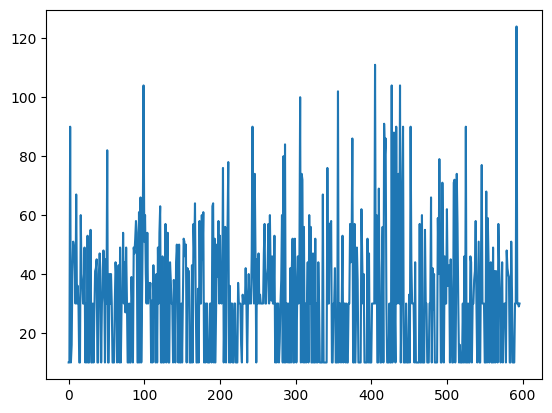

In [79]:
plt.plot(trial_len[304:])

In [80]:
len(trial_len[304:])

597

In [81]:
np.mean(trial_len[304:])

31.916247906197654

In [7]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [ ]:
best_params={
    'algo_variant': 1, 
    'algo_sampling_tau': 0.9586388653961274, 
    'algo_Z_learning_rate': 0.0009172472645240433, 
    'opt_learning_rate': 0.00033456094523569453, 
    'opt_momentum': 0.651294024078677, 
    'opt_clip_grad_param': 9.906781758764712, 
    'opt_weight_decay': 3.9731330248837407e-07
    }

In [18]:
import pandas as pd

In [19]:
inv_df = create_trial_df(study.trials[97])

In [21]:
study.trials[97].params

{'algo_variant': 0,
 'algo_sampling_tau': 0.8410173582399816,
 'algo_Z_learning_rate': 7.311623958725083e-08,
 'opt_learning_rate': 0.0005201064827291782,
 'opt_momentum': 0.8601675528455857,
 'opt_clip_grad_param': 2.261617843150461,
 'opt_weight_decay': 2.9471142855034144e-09}

<Axes: >

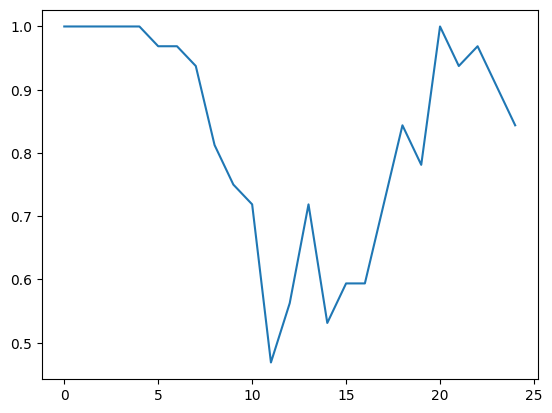

In [20]:
inv_df["invalid_trajectories"].plot()

In [7]:
study.best_trial.params

{'algo_sampling_tau_log': 0.9840271666819398,
 'algo_Z_learning_rate': 3.157262808970358e-05,
 'opt_learning_rate': 0.0002566028526773609,
 'opt_clip_grad_param_log': 32.27804232610293}

In [ ]:
plot_timeline(study)

In [ ]:
plot_param_importances(study)

In [55]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_edf(study)

In [ ]:
plot_intermediate_values(study)

In [ ]:
plot_contour(study,params=["opt_momentum","opt_learning_rate"])

In [5]:
threshold=2000
f_trials = [t for t in study.trials if t.value is not None and t.value < threshold]
f_study = optuna.create_study(direction=study.direction, pruner=study.pruner)
for t in f_trials:
    f_study.add_trial(t)

[I 2025-05-20 16:14:47,993] A new study created in memory with name: no-name-966a5982-e172-4d37-a9c0-f91abc766989


In [83]:
plot_parallel_coordinate(study,params=study.best_trial.params.keys())

In [84]:
plot_parallel_coordinate(f_study,params=study.best_trial.params.keys())

In [8]:
plot_optimization_history(f_study)

In [9]:
plot_param_importances(f_study)

In [ ]:
plot_edf(f_study)

In [ ]:
plot_intermediate_values(f_study.best_trial)

In [ ]:
plot_contour(f_study,params=["opt_momentum","opt_learning_rate"])

In [ ]:
plot_contour(f_study,params=["opt_momentum","opt_clip_grad_param"])

In [ ]:
plot_contour(f_study,params=["opt_clip_grad_param","opt_learning_rate"])

In [86]:
study.best_trial

FrozenTrial(number=721, state=TrialState.COMPLETE, values=[79.05164260864258], datetime_start=datetime.datetime(2025, 5, 18, 17, 29, 17, 971877), datetime_complete=datetime.datetime(2025, 5, 18, 18, 3, 0, 931504), params={'algo_sampling_tau_log': 0.9840271666819398, 'algo_Z_learning_rate': 3.157262808970358e-05, 'opt_learning_rate': 0.0002566028526773609, 'opt_clip_grad_param_log': 32.27804232610293}, user_attrs={'1': {'offline_loss': 3415.645263671875, 'online_loss': 1643.4791259765625, 'reward_loss': 0, 'invalid_trajectories': 1.0, 'invalid_logprob': -17.633907318115234, 'invalid_losses': 1643.4739990234375, 'backward_vs_unif': 0.0, 'logZ': -0.184650719165802, 'loss': 2529.56201171875, 'n_loss': 0.0, 'tb_loss': 2529.56201171875, 'batch_entropy': 57.66593551635742, 'traj_lens': 12.578125, 'grad_norm': 4857.21240234375, 'grad_norm_clip': 32.27810287475586, 'sampled_reward_avg': 2.678636997114156e-33, 'train_time': 3.35021710395813, 'time_spent': 7.473224401473999}, '10': {'offline_loss

In [92]:
best_run_data= study.best_trial.user_attrs

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [94]:
sorted_values = [best_run_data[k] for k in sorted(best_run_data.keys(), key=lambda x: int(x))]

In [95]:
best_run_df=pd.DataFrame(data=sorted_values)
best_run_df.head()

,offline_loss,online_loss,reward_loss,invalid_trajectories,invalid_logprob,invalid_losses,backward_vs_unif,logZ,loss,n_loss,tb_loss,batch_entropy,traj_lens,grad_norm,grad_norm_clip,sampled_reward_avg,train_time,time_spent
0,3415.645264,1643.479126,0,1.0,-17.633907,1643.473999,0.0,-0.184651,2529.562012,0.0,2529.562012,57.665936,12.578125,4857.212402,32.278103,2.678637e-33,3.350217,7.473224
1,413.406036,1560.922485,0,1.0,-26.263205,1560.917603,0.0,-0.333689,987.164246,0.0,987.164246,42.447006,13.328125,1120.716553,32.278103,2.678637e-33,3.397997,7.232537
2,172.502213,1719.952148,0,1.0,-29.112938,1719.946777,0.0,-1.010163,946.227112,0.0,946.227112,38.293282,12.750000,587.513794,32.278091,2.678637e-33,3.390749,7.472220
3,2151.181396,1732.893433,0,1.0,-24.080938,1732.888062,0.0,-2.251790,1942.037598,0.0,1942.037598,43.790737,11.968750,1020.111877,32.278080,2.678637e-33,3.198744,6.605693
4,189.399368,1519.227539,0,1.0,-22.161858,1519.222778,0.0,-3.356914,854.313416,0.0,854.313416,35.997368,12.109375,643.838684,32.278080,2.678637e-33,3.181780,6.236816


Text(0, 0.5, 'Loss')

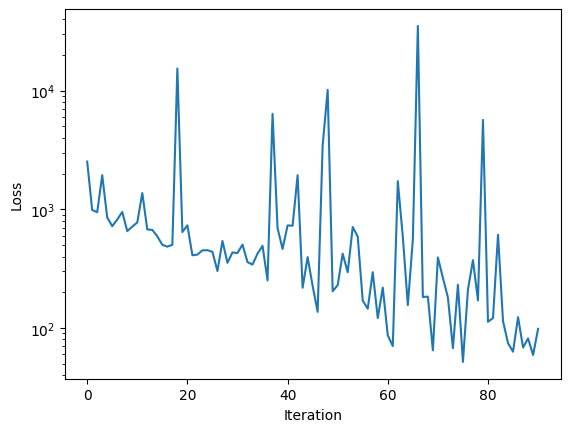

In [96]:
plt.plot(best_run_df.index, best_run_df["loss"])
plt.xlabel("Iteration")
plt.yscale("log")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

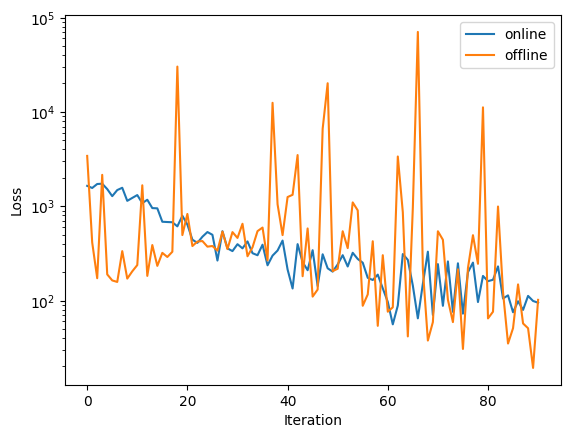

In [97]:
plt.plot(best_run_df.index, best_run_df["online_loss"],label="online")
plt.plot(best_run_df.index, best_run_df["offline_loss"],label="offline")
plt.xlabel("Iteration")
plt.legend()
plt.yscale("log")
plt.ylabel("Loss")

Text(0, 0.5, 'Invalid traj.')

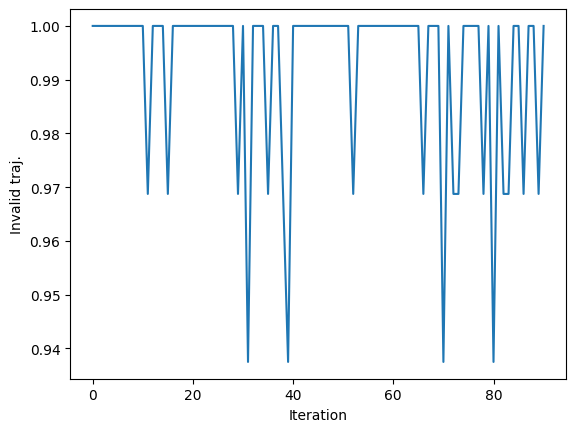

In [98]:
plt.plot(best_run_df.index, best_run_df["invalid_trajectories"])
plt.xlabel("Iteration")
plt.ylabel("Invalid traj.")

Text(0, 0.5, 'Sampled reward average')

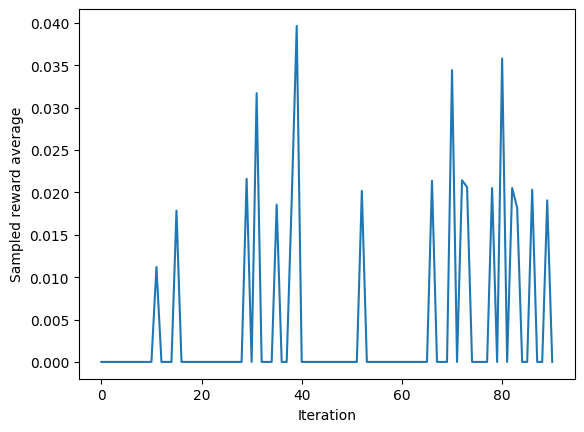

In [99]:
plt.plot(best_run_df.index, best_run_df["sampled_reward_avg"])
plt.xlabel("Iteration")
plt.ylabel("Sampled reward average")

In [74]:
trial_len = [len(t.user_attrs.keys()) for t in study.trials]

In [ ]:
plt.plot(trial_len)

In [ ]:
np.mean(trial_len)

Idea hyperparameter optimization with a noise measure as a reward instead of min loss.

I use more aligned reard functions. The best trial used only vanilla molecules

In [115]:
soted_t = study.trials
soted_t.sort(key=lambda x: x.values[0] if x.values else float("inf"))

In [16]:
def create_trial_df(trial):
    logs = trial.user_attrs
    if "1" in logs.keys():
        s_logs = [logs[k] for k in sorted(logs.keys(), key=lambda x: int(x))]
        df=pd.DataFrame(data=s_logs)
        return df
    print(f"Trial: {trial.number} Value: {trial.values}")
    return pd.DataFrame()

In [123]:
study.best_trial

FrozenTrial(number=721, state=TrialState.COMPLETE, values=[79.05164260864258], datetime_start=datetime.datetime(2025, 5, 18, 17, 29, 17, 971877), datetime_complete=datetime.datetime(2025, 5, 18, 18, 3, 0, 931504), params={'algo_sampling_tau_log': 0.9840271666819398, 'algo_Z_learning_rate': 3.157262808970358e-05, 'opt_learning_rate': 0.0002566028526773609, 'opt_clip_grad_param_log': 32.27804232610293}, user_attrs={'1': {'offline_loss': 3415.645263671875, 'online_loss': 1643.4791259765625, 'reward_loss': 0, 'invalid_trajectories': 1.0, 'invalid_logprob': -17.633907318115234, 'invalid_losses': 1643.4739990234375, 'backward_vs_unif': 0.0, 'logZ': -0.184650719165802, 'loss': 2529.56201171875, 'n_loss': 0.0, 'tb_loss': 2529.56201171875, 'batch_entropy': 57.66593551635742, 'traj_lens': 12.578125, 'grad_norm': 4857.21240234375, 'grad_norm_clip': 32.27810287475586, 'sampled_reward_avg': 2.678636997114156e-33, 'train_time': 3.35021710395813, 'time_spent': 7.473224401473999}, '10': {'offline_loss

In [131]:
sorted_t_dfs = [create_trial_df(t) for t in soted_t]

Trial: 0 Value: [1122.8600158691406]
Trial: 1 Value: [2616.603955078125]
Trial: 297 Value: None
Trial: 298 Value: None
Trial: 299 Value: None
Trial: 301 Value: None


In [132]:
len(sorted_t_dfs)

901

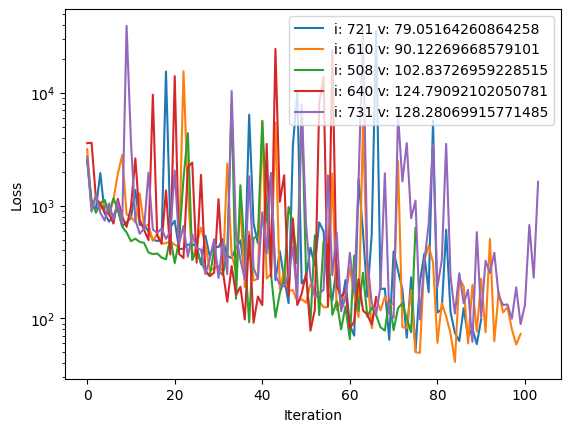

In [137]:
for i, run in enumerate(sorted_t_dfs[:5]):
    plt.plot(run.index, run["loss"], label=f"i: {soted_t[i].number} v: {soted_t[i].values[0]}")
plt.xlabel("Iteration")
plt.yscale("log")
plt.ylabel("Loss")
plt.legend()

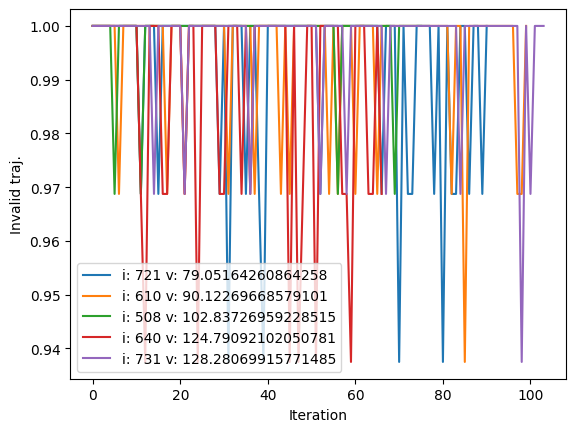

In [140]:


for i, run in enumerate(sorted_t_dfs[:5]):
    plt.plot(run.index, run["invalid_trajectories"], label=f"i: {soted_t[i].number} v: {soted_t[i].values[0]}")
plt.xlabel("Iteration")
plt.ylabel("Invalid traj.")
plt.legend()

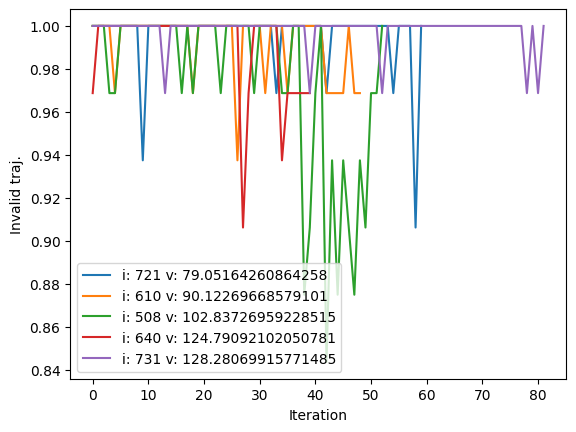

In [141]:


for i, run in enumerate(sorted_t_dfs[5:10]):
    plt.plot(run.index, run["invalid_trajectories"], label=f"i: {soted_t[i].number} v: {soted_t[i].values[0]}")
plt.xlabel("Iteration")
plt.ylabel("Invalid traj.")
plt.legend()

In [143]:
l_inval = sorted(sorted_t_dfs, key=lambda x: min(x["invalid_trajectories"]) if "invalid_trajectories" in x.keys() else 1)


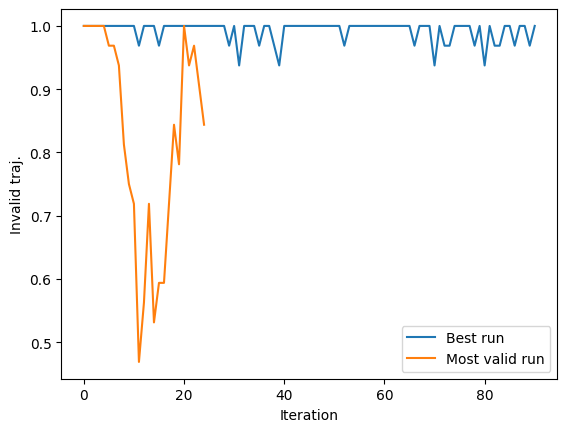

In [150]:
plt.plot(best_run_df.index, best_run_df["invalid_trajectories"], label="Best run")
plt.plot(l_inval[0].index, l_inval[0]["invalid_trajectories"], label="Most valid run")
plt.xlabel("Iteration")
plt.ylabel("Invalid traj.")
plt.legend()

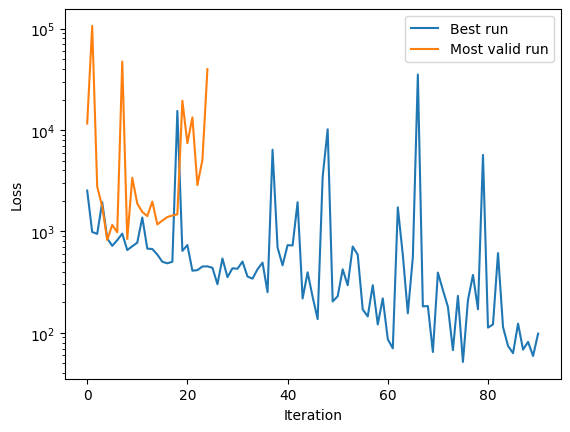

In [149]:
plt.plot(best_run_df.index, best_run_df["loss"], label="Best run")
plt.plot(l_inval[0].index, l_inval[0]["loss"], label="Most valid run")
plt.xlabel("Iteration")
plt.yscale("log")
plt.ylabel("Loss")
plt.legend()

In [148]:
np.mean(l_inval[0]["loss"][-5:])

13707.051708984374

In [153]:
index = next(i for i, df in enumerate(sorted_t_dfs) if df is l_inval[0])

In [154]:
index

873

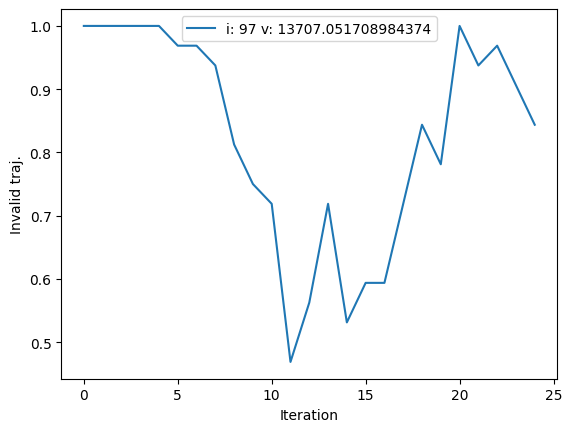

In [156]:

plt.plot(sorted_t_dfs[873].index, sorted_t_dfs[873]["invalid_trajectories"], label=f"i: {soted_t[i].number} v: {soted_t[i].values[0]}")
plt.xlabel("Iteration")
plt.ylabel("Invalid traj.")
plt.legend()

In [158]:
lval_indexes = []
for j in l_inval: 
    lval_indexes.append(next(i for i, df in enumerate(sorted_t_dfs) if df is j))

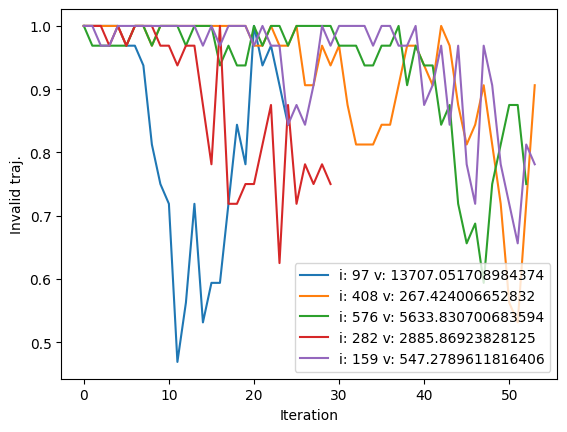

In [164]:
c = 5
for i, df in zip(lval_indexes[:c], l_inval[:c]):
    plt.plot(df.index, df["invalid_trajectories"], label=f"i: {soted_t[i].number} v: {soted_t[i].values[0]}")
    plt.xlabel("Iteration")
    plt.ylabel("Invalid traj.")
    plt.legend()

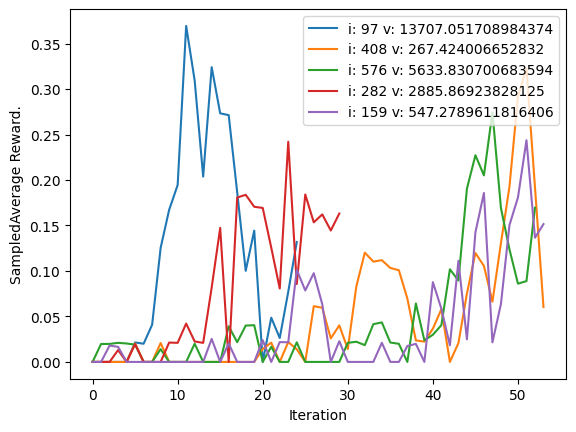

In [167]:
c = 5
for i, df in zip(lval_indexes[:c], l_inval[:c]):
    plt.plot(df.index, df["sampled_reward_avg"], label=f"i: {soted_t[i].number} v: {soted_t[i].values[0]}")
    plt.xlabel("Iteration")
    plt.ylabel("SampledAverage Reward.")
    plt.legend()

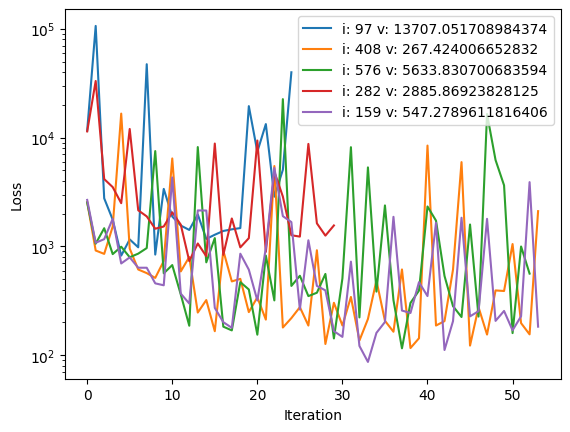

In [168]:
c = 5
for i, df in zip(lval_indexes[:c], l_inval[:c]):
    plt.plot(df.index, df["loss"], label=f"i: {soted_t[i].number} v: {soted_t[i].values[0]}")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()

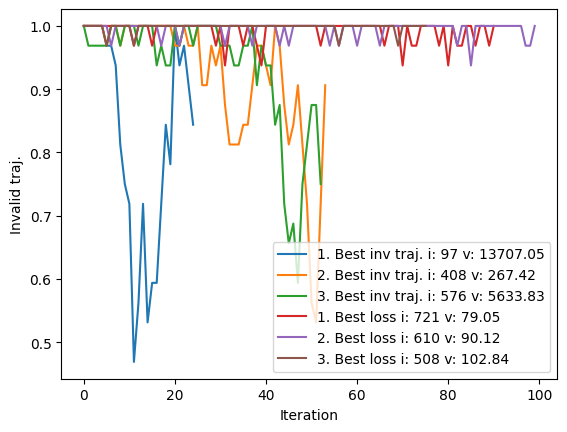

In [173]:
c = 3
k = 0
for i, df in zip(lval_indexes[:c], l_inval[:c]):
    plt.plot(df.index, df["invalid_trajectories"], label=f"{k+1}. Best inv traj. i: {soted_t[i].number} v: {round(soted_t[i].values[0],2)}")
    k+=1

for i, run in enumerate(sorted_t_dfs[:3]):
    plt.plot(run.index, run["invalid_trajectories"], label=f"{i+1}. Best loss i: {soted_t[i].number} v: {round(soted_t[i].values[0],2)}")

    
plt.xlabel("Iteration")
plt.ylabel("Invalid traj.")
plt.legend()

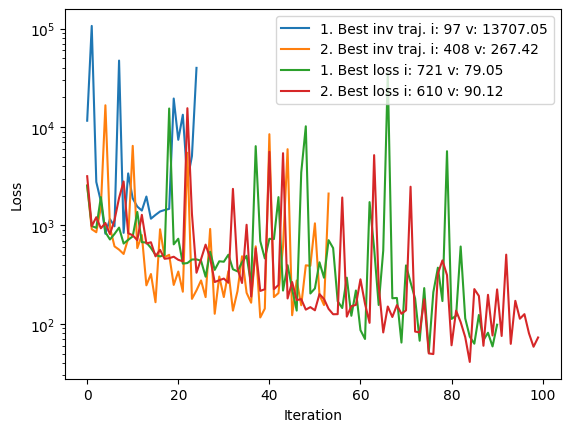

In [176]:
c = 2
k = 0
for i, df in zip(lval_indexes[:c], l_inval[:c]):
    plt.plot(df.index, df["loss"], label=f"{k+1}. Best inv traj. i: {soted_t[i].number} v: {round(soted_t[i].values[0],2)}")
    k+=1

for i, run in enumerate(sorted_t_dfs[:2]):
    plt.plot(run.index, run["loss"], label=f"{i+1}. Best loss i: {soted_t[i].number} v: {round(soted_t[i].values[0],2)}")

    
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

In [12]:
l_inval[0]

NameError: name 'l_inval' is not defined

In [1]:
study.best_trial

NameError: name 'study' is not defined